In [ ]:
import tensorflow as tf
from keras.utils import plot_model
from keras.models import Sequential
from keras.models import Model
from keras import backend as K
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate 
from keras.preprocessing import image
import numpy as np
from PIL import Image
import os, cv2

config = {
    "focus": {
        "type": "classification",
        "model_type": "VGG16",
        "name": "Определение качества",
        "path": "frame_qua.h5",
        "labels": {
            0: "focus", 
            1: "not_focus",
            2: "part_focus"
        }
    },
    "matherial_type":{
        "type": "classification",
        "model_type": "VGG16",
        "name": "Определние типа материала",
        "path": "math_type.h5",
        "labels": {
            0: "AZ31_150",
            1: "AZ31_200",
            2: "AZ31_250",
            3: "AZ31_300",
            4: "AZ31_SRC",
            5: "Brass",
            6: "Cooper",
            7: "Mg",
            8: "Steel"
        }
    },
    "mark_steel":{
        "type": "classification",
        "model_type": "VGG16",
        "name": "Опеределение марки стали",
        "path": "steel_mark.h5",
        "labels": {
            0: "09Г2С",
            1: "12Х18Н10Т",
            2: "15ХМ",
            3: "20Х13НЛ",
            4: "20ХГ",
        }
    },
    "defects": {
        "type": "classification",
        "model_type": "VGG16",
        "name": "Определение типа дефекта",
        "path": "defects.h5",
        "labels": {
            0: "Crazing",
            1: "Inclusion",
            2: "Patches",
            3: "Pitted",
            4: "Rolled",
            5: "Scratches",
        }
    },
    "grains": {
        "type": "segmentation",
        "model_type": "Unet",
        "name": "Локализация зерен",
        "path": "grains.h5",
        "labels": {}
    }
}

class ModelClassification():
    def __init__(self, settings):
        model_name = settings['model_type']
        self.img_width, self.img_height = 224, 224
        num_classes = len(settings['labels'])
        self.labels = settings['labels']
        if model_name == "MobileNet":
            from keras.applications import MobileNet
            base_model = MobileNet(
                input_shape=(self.img_width, self.img_height, 3),
                include_top=False, #True
                classes=num_classes,
            )
        if model_name == "VGG16":
            from keras.applications import VGG16
            base_model = VGG16(
                input_shape=(self.img_width, self.img_height, 3),
                include_top=False, #True
                classes=num_classes,
            )
        self.model = Sequential()
        self.model.add(base_model)
        self.model.add(Dropout(0.1))
        self.model.add(GlobalAveragePooling2D(name='global_average_pooling2d'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(num_classes, activation='softmax', name='predictions'))
        self.model.load_weights(os.path.join(os.getcwd(), "models", settings['path']), skip_mismatch=True)
        # self.model.summary()
        # self.model.get_weights()
        # return self.model

    def predict(self, img_path):
        x = img_path
        if x.shape != (self.img_width, self.img_height, 3):
            x = np.resize(x, (self.img_width, self.img_height, 3))

        # Нормализуем изображение
        x = x / 255
        
        x = np.expand_dims(x, axis=0)  # добавляем размер батча

        # Предсказываем
        preds = self.model.predict(x)
        pred_prob = np.max(preds)
        pred_class_idx = np.argmax(preds)
        print(preds, pred_prob, pred_class_idx)
        # Получаем метку класса, если список меток предоставлен
        pred_label = self.labels[pred_class_idx] if self.labels else str(pred_class_idx)

        return pred_label, pred_prob


class Preproccessing():
    def open_image(img_path:str): 
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        return image
    @staticmethod
    def fragmentation(image, crop: bool = True, rows:int = 6, cols:int = 8):
        # Загружаем изображение
        if image is None:
            raise ValueError("Не удалось загрузить изображение по указанному пути.")

        height, width = image.shape[:2]
        fragment_height = height // rows
        fragment_width = width // cols

        fragments = []
        if crop:
            for r in range(rows):
                for c in range(cols):
                    y1 = r * fragment_height
                    y2 = (r + 1) * fragment_height if r != rows - 1 else height
                    x1 = c * fragment_width
                    x2 = (c + 1) * fragment_width if c != cols - 1 else width

                    fragment = image[y1:y2, x1:x2]
                    fragments.append(fragment)
        else:
            fragments.append(image)
        return fragments

    @staticmethod
    def defragmentation(fragments, rows: int, cols: int, original_width: int, original_height: int):
        # Создаем пустое изображение нужных размеров
        reconstructed_image = np.zeros((original_height, original_width, 3), dtype=fragments[0].dtype)

        fragment_idx = 0
        # Предполагаем, что фрагменты идут по порядку: по строкам, по столбцам
        for r in range(rows):
            for c in range(cols):
                # Размер текущего фрагмента
                frag = fragments[fragment_idx]
                frag_h, frag_w = frag.shape[:2]

                # Расчет координат вставки
                y1 = r * (original_height // rows)
                y2 = y1 + frag_h
                x1 = c * (original_width // cols)
                x2 = x1 + frag_w

                # Вставляем фрагмент
                reconstructed_image[y1:y2, x1:x2] = frag
                fragment_idx += 1

        return reconstructed_image
class ModelSegmentation():
    def __init__(self, settings):
        self.sz = (256, 256, 3)
        self.model = self.unet()
        self.model.load_weights(os.path.join(os.getcwd(), "models", settings['path']))

    def mean_iou(y_true, y_pred):
        yt0 = y_true[:,:,:,0]
        yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
        inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
        union = tf.math.count_nonzero(tf.add(yt0, yp0))
        iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
        return iou

    def unet(self):
        x = Input(self.sz)
        inputs = x
    
    #down sampling 
        f = 8
        layers = []
    
        for i in range(0, 6):
            x = Conv2D(f, 3, activation='relu', padding='same') (x)
            x = Conv2D(f, 3, activation='relu', padding='same') (x)
            layers.append(x)
            x = MaxPooling2D() (x)
            f = f*2
        ff2 = 64 
    
    #bottleneck 
        j = len(layers) - 1
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j -1 
    
    #upsampling 
        for i in range(0, 5):
            ff2 = ff2//2
            f = f // 2 
            x = Conv2D(f, 3, activation='relu', padding='same') (x)
            x = Conv2D(f, 3, activation='relu', padding='same') (x)
            x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
            x = Concatenate(axis=3)([x, layers[j]])
            j = j -1 
        
    
    #classification 
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        outputs = Conv2D(1, 1, activation='sigmoid') (x)
    
    #model creation 
        self.model = Model(inputs=[inputs], outputs=[outputs])
        # self.model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [self.mean_iou])
        
        return self.model

    def predict(self, img_path):
        x = img_path
        src_shape = x.shape
        interpolation = cv2.INTER_LINEAR_EXACT
        if x.shape != self.sz:
            x = cv2.resize(src=x, dsize=(self.sz[1], self.sz[0]), interpolation=interpolation)

        # Нормализуем изображение
        x = x / 255
        
        x = np.expand_dims(x, axis=0)
        pred = self.model.predict(x)
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        msk_bin = msk[..., 0]*255
        print(src_shape, msk_bin.shape)
        msk_bin = cv2.resize(src=msk_bin, dsize=(src_shape[1], src_shape[0]), interpolation=interpolation)
        print(msk_bin.shape)
        contours_pred, _ = cv2.findContours(msk_bin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return contours_pred

2025-07-01 16:01:00.035811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/petr/PycharmProjects/Graph/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
models = {}
for model in config:
    settings = config[model]
    if settings['type'] == "classification":
        model_class = ModelClassification(settings)
    elif settings['type'] == "segmentation":
        model_class = ModelSegmentation(settings)
    models[model] = model_class

In [3]:
class Cascad():
    models = {}
    def __init__(self, models):
        self.models = models

    def predict(self, img_path:str, crop: bool, params):
        frames = Preproccessing.fragmentation(img_path, crop, params[0], params[1])
        grains_list = []
        areas = []
        for i, frame in enumerate(frames):
            # focus = self.models['focus'].predict(frame)
            # print(focus)
            # if focus in [0, 2]:
                # matherial_type = self.models['matherial_type'].predict(frame)
                # print(matherial_type)
                # if matherial_type == 8: 
                #     mark_steel = self.models['mark_steel'].predict(frame)
                
                # if matherial_type in [0, 1, 2, 3, 4, 7]:

                grains = self.models['grains'].predict(frame)
                grains_list.extend(grains)
                result_img = frame.copy()
                result_img = cv2.drawContours(result_img, grains, -1, (255, 0, 0), 2)  # зеленый
                os.makedirs(img_path.split(".")[0], exist_ok=True)
                result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
                cv2.imwrite(f'{img_path.split(".")[0]}/{img_path.split(".")[0]}_{i}.{img_path.split(".")[1]}', result_img)
                # defects = self.models['defects'].predict(frame)
                # defects_local = self.models['defects_local'].predict(frame)
        for grain in grains_list:
            area = cv2.contourArea(grain)
            if area > 100: areas.append(area)
        
        print(areas)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
(644, 858, 3) (256, 256)
(644, 858)


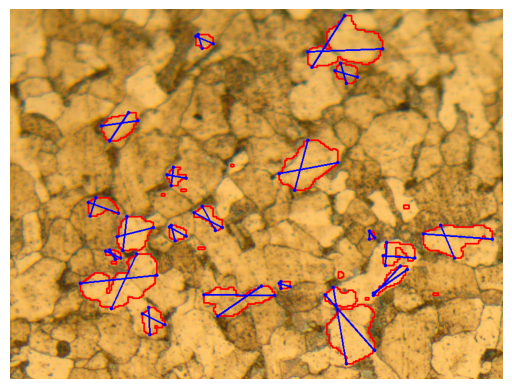

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
(644, 858, 3) (256, 256)
(644, 858)


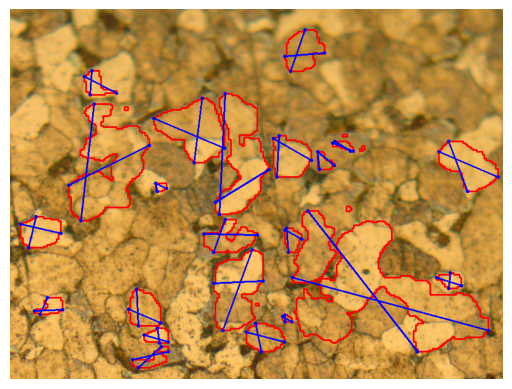

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
(644, 860, 3) (256, 256)
(644, 860)


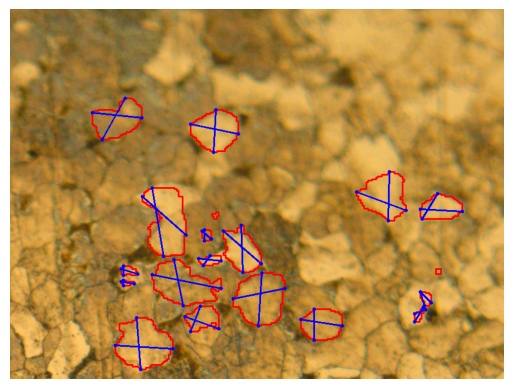

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
(644, 858, 3) (256, 256)
(644, 858)


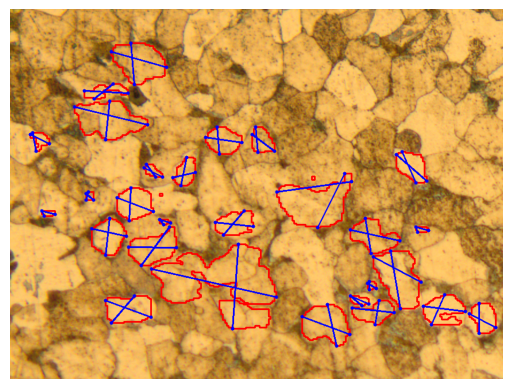

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
(644, 858, 3) (256, 256)
(644, 858)


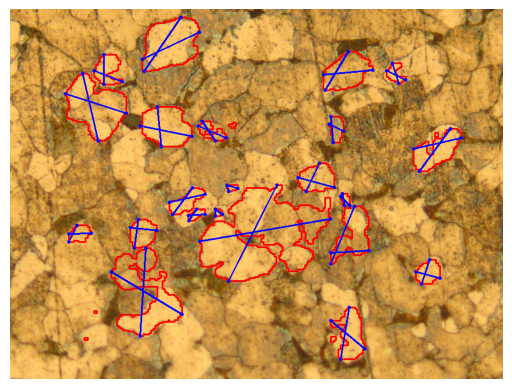

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(644, 860, 3) (256, 256)
(644, 860)


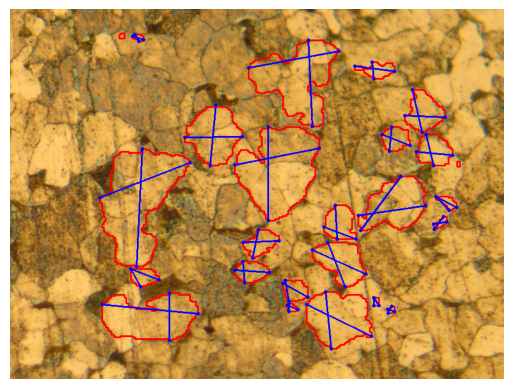

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(644, 858, 3) (256, 256)
(644, 858)


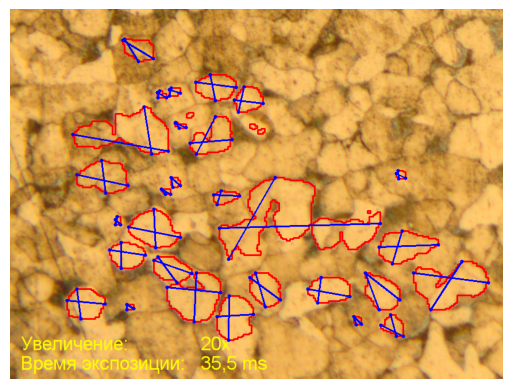

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
(644, 858, 3) (256, 256)
(644, 858)


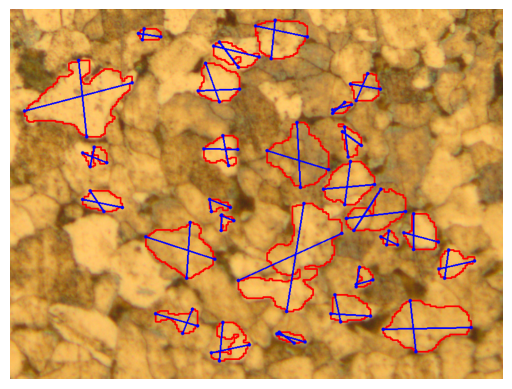

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(644, 860, 3) (256, 256)
(644, 860)


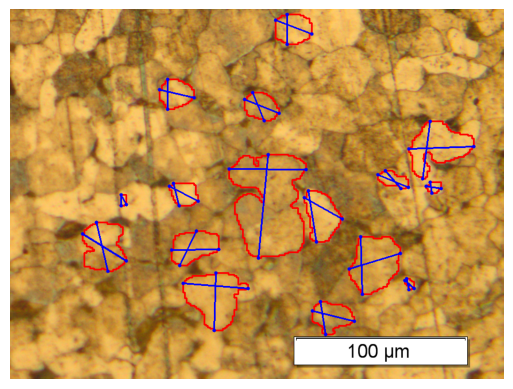

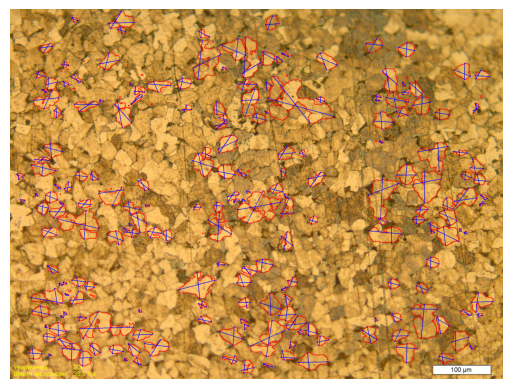

In [31]:
import matplotlib.pyplot as plt
areas = []
dv = []
dh = [] 

def calc_linear_size(contour):
    leftmost = tuple(contour[contour[:, :, 0].argmin()][0])
    rightmost = tuple(contour[contour[:, :, 0].argmax()][0])
    topmost = tuple(contour[contour[:, :, 1].argmin()][0])
    bottommost = tuple(contour[contour[:, :, 1].argmax()][0])
    distance_horizontal = np.linalg.norm(np.array(rightmost) - np.array(leftmost))
    distance_vertical = np.linalg.norm(np.array(bottommost) - np.array(topmost))
    return {
        "l": leftmost,
        "r": rightmost,
        "t": topmost,
        "b": bottommost
    }, {
        "dh": distance_horizontal,
        "dv": distance_vertical 
    } 

def predict(img_path:str, crop: bool, params):
    image = Preproccessing.open_image(img_path)
    frames = Preproccessing.fragmentation(image, crop, params[0], params[1])
    temp_frames = []
    for i, frame in enumerate(frames):
        grains = models['grains'].predict(frame)
        
        result_img = frame.copy()
        result_img = cv2.drawContours(result_img, grains, -1, (255, 0, 0), 2)  # зеленый
        os.makedirs(img_path.split(".")[0], exist_ok=True)
        # result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f'{img_path.split(".")[0]}/{img_path.split(".")[0]}_{i}.{img_path.split(".")[1]}', result_img)
        for grain in grains:
            area = cv2.contourArea(grain)
            if area > 100: 
                areas.append(area)

                pp, ls = calc_linear_size(grain)
                dv.append(ls['dv'])
                dh.append(ls['dh'])
                color = (0, 0, 255)
                result_img = cv2.circle(result_img, pp['l'], 3, color, -1)
                result_img = cv2.circle(result_img, pp['r'], 3, color, -1)
                result_img = cv2.circle(result_img, pp['t'], 3, color, -1)
                result_img = cv2.circle(result_img, pp['b'], 3, color, -1)
                result_img = cv2.line(result_img, pp['l'], pp['r'], color, 2)
                result_img = cv2.line(result_img, pp['t'], pp['b'], color, 2)
        temp_frames.append(result_img)
        plt.imshow(result_img)
        plt.axis('off')
        plt.show()
    
    if crop:
        result_frame = Preproccessing.defragmentation(temp_frames, params[0], params[1], image.shape[1], image.shape[0])
    else:
        result_frame = frames[0]
    plt.imshow(result_frame)
    plt.axis('off')
    plt.show()
        
        

predict('test4.png', crop=True, params=[3, 3])

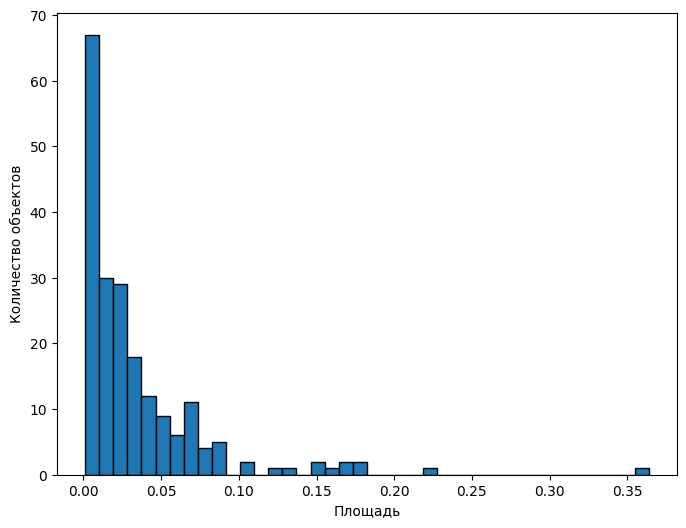

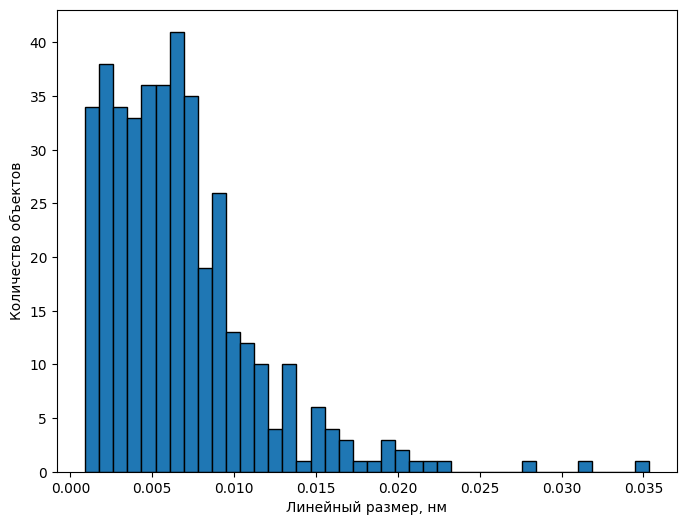

In [33]:
plt.figure(figsize=(8, 6))
plt.hist(np.array(areas)/100000, bins=40, edgecolor='black')
plt.xlabel('Площадь')
plt.ylabel('Количество объектов')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(np.array(dh + dv)/10000, bins=40, edgecolor='black')
plt.xlabel('Линейный размер, нм')
plt.ylabel('Количество объектов')
plt.show()
